# Задача кластеризации на  кейс-чемпионате OilCase

## Задача  - построить карту фациальных зон( различаются ПС-каротажными сигналами), которая бы отображала пространственные закономерности процесса седиментации( распределение песчанных и глинистых тел )месторождения "Цифровое"(1911 скважин) 

## Данные - таблица формата XYZ, где Z - одномерный сигнал ПС-каротажа(предварительно отнормированы).Формирование файла с прогнозом должно быть c сохранением исходной индексации, т.е. должна сохраниться привязка метки кластера к координатам XY 

## Метрика - определить самостоятельно

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import v_measure_score
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

Загрузим таблицу с координатами и каротажными сигналами

In [2]:
df =  pd.read_pickle('OilCase/curves.pkl')
df.sample(5)

,X,Y,log
443,11,14,"[0.595, 0.595, 0.595, 0.595, 0.595, 0.57555555..."
1367,35,2,"[0.595, 0.595, 0.55611111, 0.27611111, 0.15166..."
1439,36,35,"[0.595, 0.435555555, 0.27611111, 0.15166667, 0..."
218,5,23,"[0.5347386034680331, 0.5347386034680331, 0.534..."
29,0,29,"[0.595, 0.55611111, 0.12758863, 0.13611111, 0...."


Инжиниринг признаков

In [3]:
df['log_len'] = df['log'].apply(lambda x: len(x))
df['min'] = df['log'].apply(lambda x: min(x))
df['max'] = df['log'].apply(lambda x: max(x))
df['median'] = df['log'].apply(lambda x: np.median(x))
df['75quant'] = df['log'].apply(lambda x: np.quantile(x, 0.75))
df['varlog'] = df['log'].apply(lambda x: np.var(x))
df['rate_of_change'] = (df['max'] - df['min'])/df['log_len']

df = df.drop(['log','log_len'], axis=1)

df = df.astype(float)

Построим таблицу корреляции для выявления мультиколлинеарности

In [4]:
df.iloc[:, 2:].corr()

,min,max,median,75quant,varlog,rate_of_change
min,1.000000,0.046818,0.560041,0.547079,-0.344764,-0.142431
max,0.046818,1.000000,0.440996,0.501074,0.689513,0.230904
median,0.560041,0.440996,1.000000,0.980308,0.437889,-0.081756
75quant,0.547079,0.501074,0.980308,1.000000,0.469884,-0.089152
varlog,-0.344764,0.689513,0.437889,0.469884,1.000000,0.306534
rate_of_change,-0.142431,0.230904,-0.081756,-0.089152,0.306534,1.000000


Вспомогательный инструмент - словарь “код фации - название”

In [5]:
typegis = {
    '0' : 'Головных частей разрывных течений',
    '1' : 'Барьерных островов',
    '2' : 'Устьевых баров',
    '3' : 'Вдольбереговых баров (регрессивных) и прибрежных валов',
    '4' : 'Забаровых лагун и вдольбереговых промоин',
    '5' : 'Открытого моря и крупных морских заливов',
    '6' : 'Промоин разрывных течений',
    '7' : 'Пляжей',
    '8' : 'Вдольбереговых баров (трансгрессивных) и прибрежных валов',
    '9' : 'Гребней штормовых волн и приливных течений',
    '10' : 'Русловых отмелей спрямленных рек',
    '11' : 'Русловых отмелей фуркирующих рек (горного типа) и временных потоков',
    '12' : 'Русловых отмелей равнинных меандрирующих рек',
    '13' : 'Пески разливов',
    '14' : 'Пойменных озер и болот',
    '15' : 'Береговых валов',
    '16' : 'Временно заливаемых участков пойм',
    '17' : 'Приморских болот (маршей, лайд и др.)',
    '18' : 'Каньоны и каналы стока (питающие)',
    '19' : 'Проксимальные турбидиты и зерновые потоки',
    '20' : 'Средние (переходные) турбидиты',
    '21' : 'Дистальные турбидиты',
    '22' : 'Дно бассейна',
    '23' : 'Фации склона',
    '24' : 'Околоканальный вал',
    '25' : 'Верхний веер склона',
    '26' : 'Оползни',
    '27' : 'Дельтовый канал',
    '28' : 'Проксимальная часть дельты',
    '29' : 'Средняя часть дельты',
    '30' : 'Дистальная часть дельты',
    '31' : 'Продельта',
    '32' : 'Дюн',
    '33' : 'Empty'
}

Построим график,  по которому можно определить оптимальное количество кластеров - количество, на котором график выходит на плато

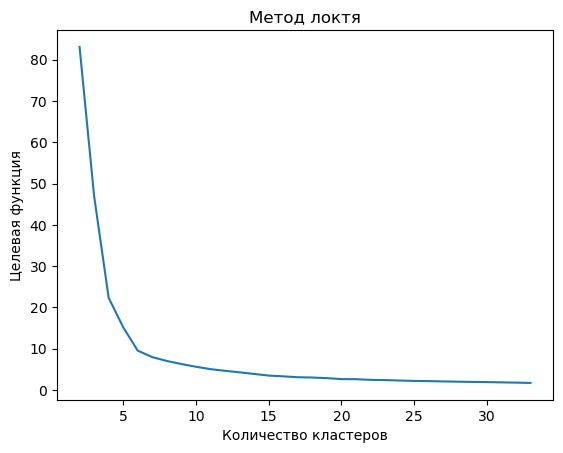

In [6]:
X = df.iloc[:, 2:].values
inertia = []
for k in range(2, 34):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 34), inertia)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Целевая функция')
plt.show() 

Оптимальное количество кластеров - 6

In [7]:
kmeans = KMeans(n_clusters=6,random_state = 42)

X = df.iloc[:, 2:].values
kmeans.fit(X)

df['predict'] = kmeans.predict(X)
X = df.drop(['predict'], axis=1).values

labels = df['predict'].values
sc = silhouette_score(X,labels)
print("SC: ", sc)
print("Целевая функция:",kmeans.inertia_)

SC:  -0.1340229652665776
Целевая функция: 9.531664531116409


Качество модели KMeans оцениваем по сочетанию значений двух метрик :

1. Silhouette Score (SC) - это метрика, которая оценивает качество кластеризации, основываясь на среднем значении коэффициента силуэта для всех точек данных. Коэффициент силуэта измеряет, насколько точка данных похожа на свой собственный кластер по сравнению с другими кластерами. Значение SC может быть от -1 до 1, где более высокое значение указывает на лучшую кластеризацию.

2. Целевая функция (Inertia) - это сумма квадратов расстояний каждой точки данных до центроидов их соответствующих кластеров. Целевая функция является мерой внутрикластерной вариации и стремится быть минимальной. Она позволяет оценить компактность и плотность кластеров. Чем меньше значение целевой функции, тем лучше кластеризация.

Таким образом,необходимо увеличивать значение первой метрики и минимизировать значение второй.

Сгенерированные признаки и подбор оптимального числа кластеров помогли добиться оптимального сочетания метрик, теперь можно строить карту в цвете для интерпретации.

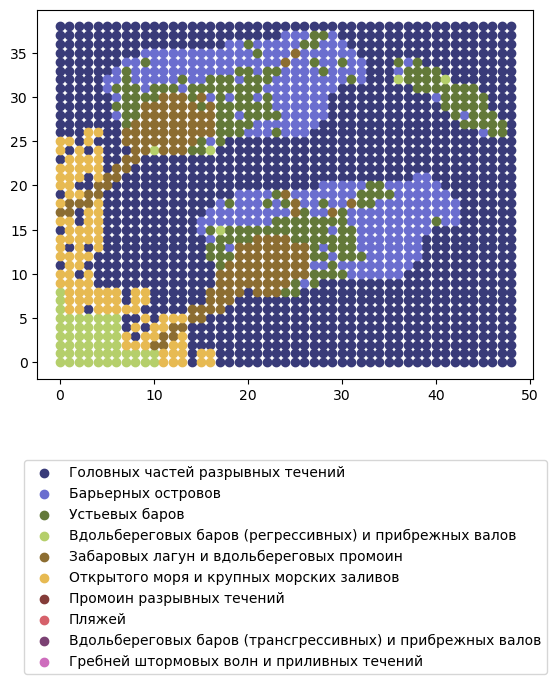

In [8]:
cluster_colors = {i: plt.cm.tab20b(i / 10) for i in range(10)}

fig, ax = plt.subplots()

for label, color in cluster_colors.items():
    clustered_points = df[df['predict'] == label]
    ax.scatter(clustered_points['X'], clustered_points['Y'], color=color,label=label)

# замена легенды цифровых значений их соответствующими наименованиями из словаря typegis
legend_labels = [typegis[str(label)] for label in range(10)]
ax.legend(labels=legend_labels)
ax.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.show()

In [9]:
df_predict = df[['predict']]
df_predict

,predict
0,3
1,3
2,3
3,3
4,3
...,...
1906,0
1907,0
1908,0
1909,0


## Выводы

Как оптимизировали метрики:

1.Создавали фичи из столбца , содержащего информацию о каротажном сигнале

2.Подбирали оптимальное число кластеров методом локтя 

3.Подбирали оптимальные метрики

Какие идеи не сработали:

1.Создать фичи из двух координат 

2.Масштабировать признаки 

3.Удалить мультиколлинеарность

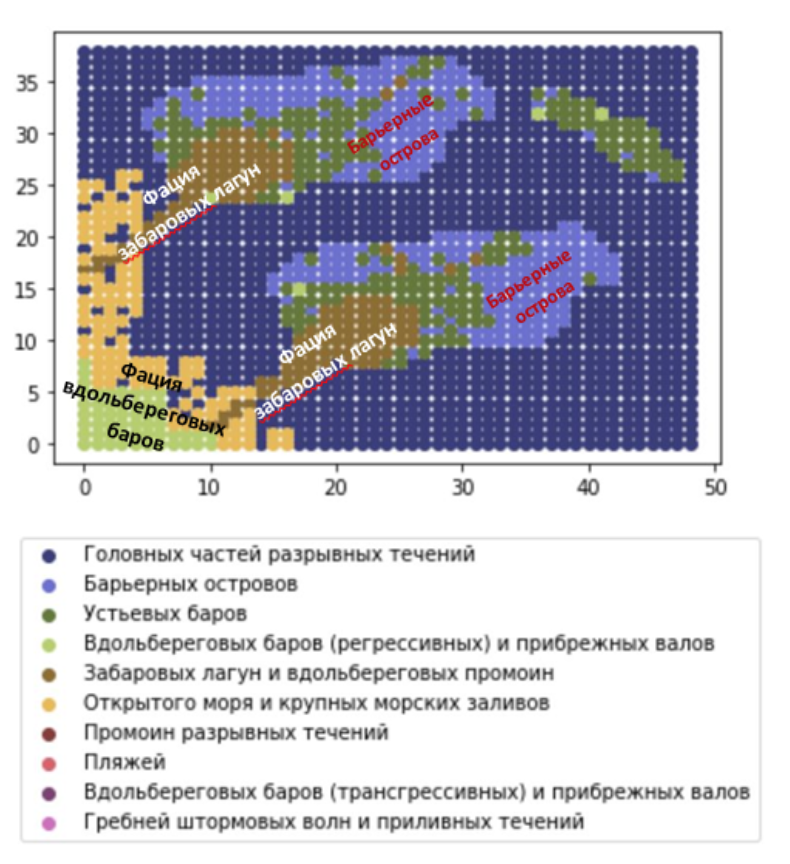

In [11]:
Image(filename='OilCase/6.PNG')

Для интерпретации итоговой карты(вероятная обстановка осадконакопления) изучена необходимая литература по домену (основы нефтяной промышленности):

При интерпретации итоговой карты бросается в глаза фация забаровых лагун. Образованию лагуны предшествует возникновение между берегом и растущим баром береговой промоины. При достижении баром поверхности моря или образовании барьерного острова вдольбереговая промоина превращается в лагуну. Лагуны это мелководные бассейны, чаще всего вытянутые вдоль морских побережий и отделенные от открытого моря песчаными отмелями (барами) или барьерными островами. Условия осадконакопления в пределах лагун характеризуются ограниченной площадью, малыми глубинами, застойностью водной среды. Вследствие этого в них накапливаются преимущественно илы с высоким содержанием органического вещества либо хемо-генные осадки.

При постоянной волновой деятельности образуются подводные валы, которые представляют собой вытянутые валообразные скопления обломочного материала, отделенные от берега вдольбереговыми промоинами. По мере роста каждого подводного вала в высоту он начинает служить все большим препятствием для волн, которые откладывают на его поверхности все новые и новые порции терригенного материала. Часть этого материала переносится волнами через гребень вала на его внутренний (обращенный в сторону берега) склон, в результате чего вал растет вверх, постепенно перемещаясь в сторону берега и превращаясь во вдольбереговой бар.

Таким образом, можно сделать вывод, что область осадконакопления на рассматриваемой карте - Морская. Именно в прибрежной части моря происходит формирование разнообразных песчаных образований, среди которых необходимо отметить следующие: устьевые и вдольбереговые бары, подводные валы, барьерные острова, косы, пляжи, а также отложения, связанные с вдольбереговыми и разрывными течениями.